In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Alternative sea-salt correction methodology for Ireland

Our current sea-salt correction methodology for Mg, Ca and SO4 assumes (i) that all chloride is marine, and (ii) that no fractionation takes place between evaporation and deposition. These coarse assumptions work OK in many regions, but lead to negative values for "corrected" Mg* and SO4* in some of the Irish lakes. See the e-mail from Julian received 20.06.2019 at 16.22 for further details.

Apparently some labs tend to significantly overestimate chloride and Julian has suggested using Na as a tracer instead (subject to the caveats in Julian's e-mail). This notebook compares results obtained using correction methods based on Cl versus Na.

As a starting point, I've extracted all the ICPW data for the Irish lakes from 1990 to the present for Ca, Mg and SO4 (the three parameters we want to correct), plus Cl and Na.

## 1. Raw dataset

In [2]:
# Read data
xl_path = r'../../../Thematic_Trends_Report_2019/ireland_high_chloride.xlsx'
df = pd.read_excel(xl_path, sheet_name='DATA')

# Suspect that values of *exactly* zero are errors
df[df==0] = np.nan

df.head()

,station_id,station_code,station_name,date,Ca,Mg,SO4,Cl,Na,ECa,EMg,ESO4,ECl,ENa,ECa*,EMg*,ESO4*,ENa*
0,23552,IE01,"Wicklow, Glendalough, Lake Upper, Mid Lake",1990-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23552,IE01,"Wicklow, Glendalough, Lake Upper, Mid Lake",1991-10-05,1.61,0.96,NaN,NaN,5.83,80.339,78.973,NaN,NaN,253.591,NaN,NaN,NaN,NaN
2,23552,IE01,"Wicklow, Glendalough, Lake Upper, Mid Lake",1992-06-11,1.67,0.68,4.13,6.7,6.38,83.333,55.939,85.986,188.983,277.514,76.341,18.899,66.521,115.178
3,23552,IE01,"Wicklow, Glendalough, Lake Upper, Mid Lake",1992-10-28,1.5,0.71,3.46,6.59,4.33,74.850,58.407,72.037,185.880,188.344,67.973,21.975,52.891,28.674
4,23552,IE01,"Wicklow, Glendalough, Lake Upper, Mid Lake",1993-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Reference values for sea water

The numbers below are taken from the World Data Centre for Precipitation Chemistry (WDCPC; PDF [here](ftp://sunbay.asrc.cestm.albany.edu/pub/qasac/sag-doc/pdf/AppendG02.17.PDF)), except for Ca, which I've taken from [here](https://www.lenntech.com/composition-seawater.htm).

In [3]:
data = {'par':      ['SO4', 'Mg', 'Ca', 'Na', 'Cl'],
        'mol_mass': [96.06, 24.31, 40.08, 22.99, 35.45],
        'valency':  [2, 2, 2, 1, 1],
        'sw_mgpl':  [2700, 1290, 400, 10800, 19374]}

sw_df = pd.DataFrame(data)

sw_df['sw_ueqpl'] = 1000 * sw_df['valency'] * sw_df['sw_mgpl'] / sw_df['mol_mass']

sw_df

,par,mol_mass,valency,sw_mgpl,sw_ueqpl
0,SO4,96.06,2,2700,56214.865709
1,Mg,24.31,2,1290,106129.164953
2,Ca,40.08,2,400,19960.079840
3,Na,22.99,1,10800,469769.464985
4,Cl,35.45,1,19374,546516.220028


As expected, the $\mu eq/l$ concentrations of Na and Cl in sea water are roughly the same, but the ratio is not exactly 1:1. For the sea-salt correction, we need the ratio of SO4, Ca and Mg to Na and to Cl.

In [4]:
corr_facs = {}
for par in ['SO4', 'Ca', 'Mg']:
    sw_par = sw_df.query('par == @par')['sw_ueqpl'].values[0]
    sw_cl = sw_df.query('par == "Cl"')['sw_ueqpl'].values[0]
    sw_na = sw_df.query('par == "Na"')['sw_ueqpl'].values[0]
    
    ratio_cl = sw_par / sw_cl
    ratio_na = sw_par / sw_na
    
    corr_facs['%s2cl' % par.lower()] = ratio_cl
    corr_facs['%s2na' % par.lower()] = ratio_na
    
    print(f'{par:3}:Cl   {ratio_cl:.3f}')
    print(f'{par:3}:Na   {ratio_na:.3f}')
    print('')

SO4:Cl   0.103
SO4:Na   0.120

Ca :Cl   0.037
Ca :Na   0.042

Mg :Cl   0.194
Mg :Na   0.226



The ratios above for chloride are virtually the same as documented in our current workflow ([here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part7.ipynb#3.1.-Sea-salt-correction)), so I assume the new ratios for Na should also be compatible. Note that the ration of `SO4:Na` is about 20% higher than `SO4:Cl`, which might actually exacerbate the problem of negative values.

## 2. Compare Cl to Na in Irish lakes

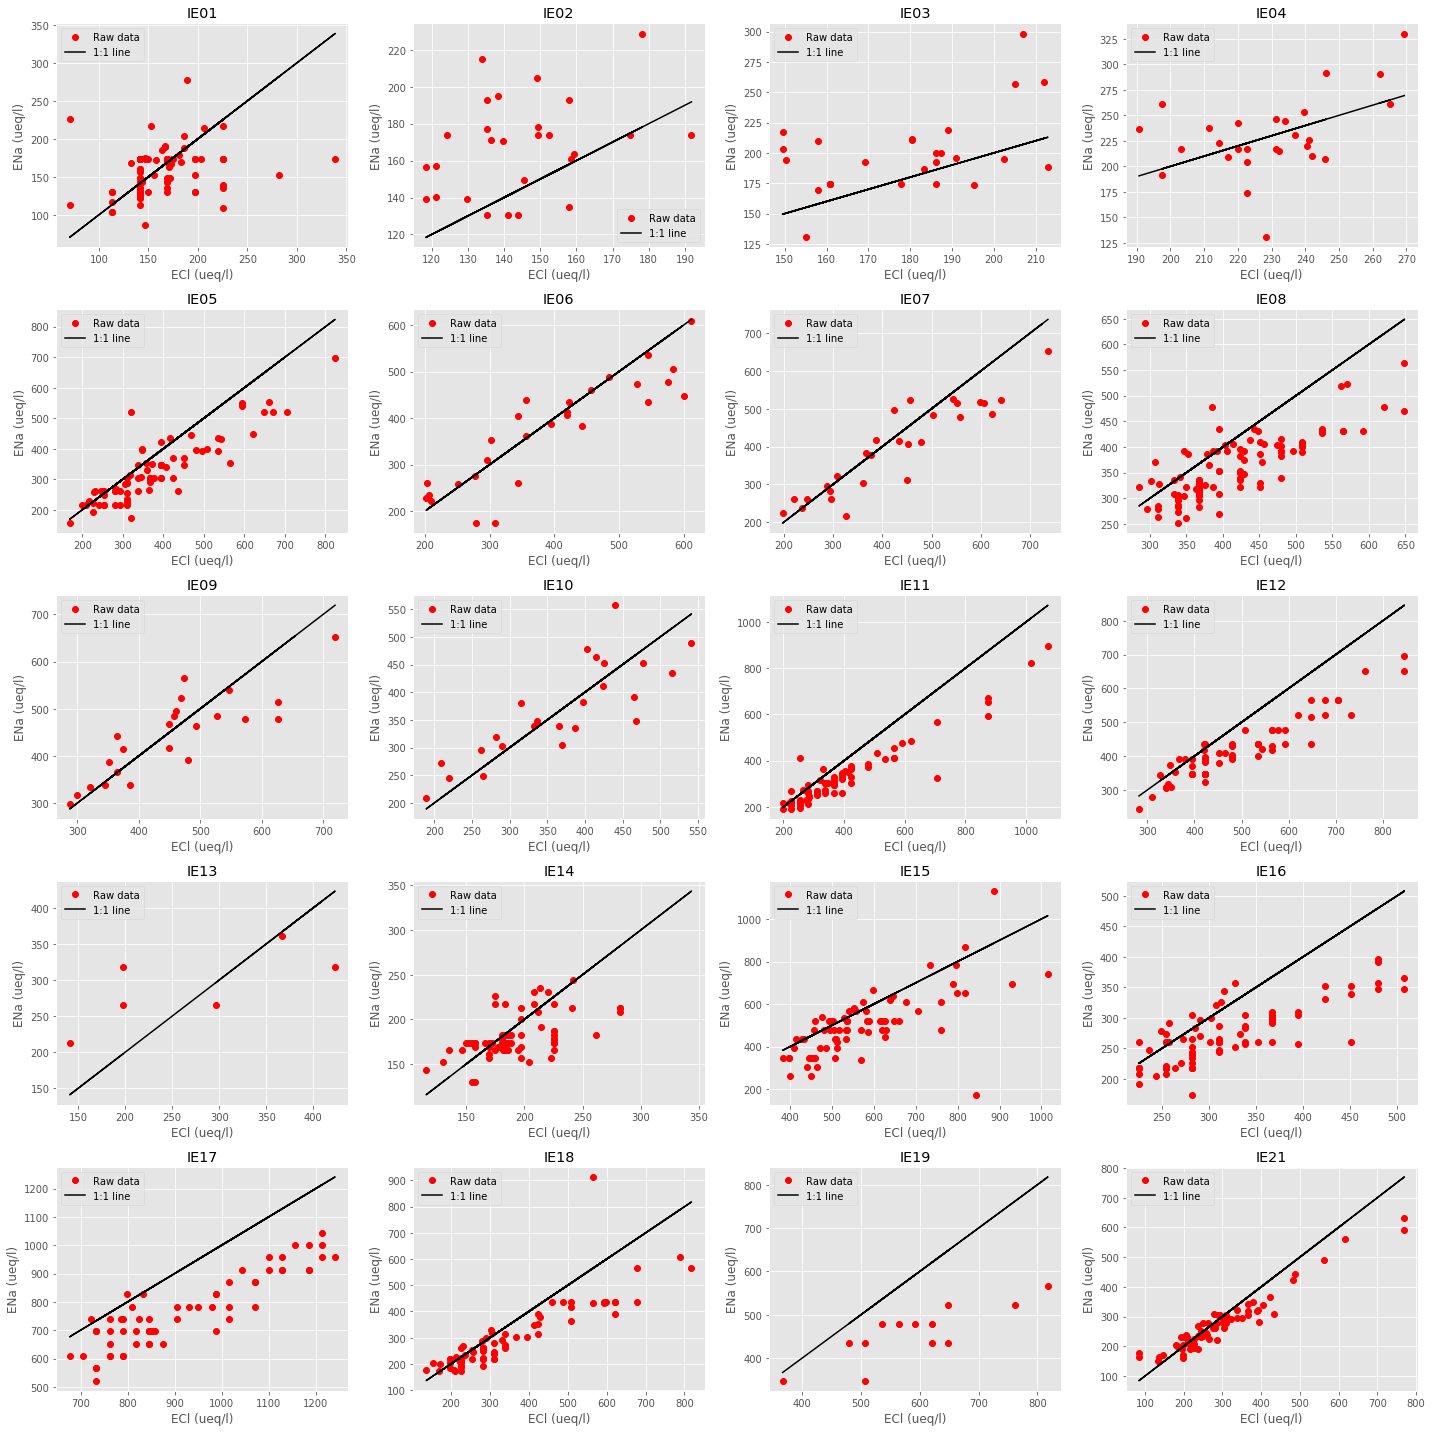

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
axes = axes.flatten()

for idx, stn in enumerate(df['station_code'].unique()):
    df_stn = df.query('station_code == @stn')
    axes[idx].plot(df_stn['ECl'], df_stn['ENa'], 'ro', label='Raw data')
    axes[idx].plot(df_stn['ECl'], df_stn['ECl'], 'k-', label='1:1 line')
    
    axes[idx].set_title(stn)
    axes[idx].set_xlabel('ECl (ueq/l)')
    axes[idx].set_ylabel('ENa (ueq/l)')
    axes[idx].legend(loc='best')
    
plt.tight_layout()

Based on these plots, I'd say concentrations of Na are also pretty high in these lakes (although in most cases Cl is even higher). Looking at this, I suspect using Na as a marine "tracer" instead of Cl will still lead to negative values.

## 4. Sea-salt correction for SO4

Using our original methodology, the corrected series for SO4* has the most negative values. The code below compares boxplots of SO4* calculated using Cl (red boxes) versus Na (blue boxes) for each site.

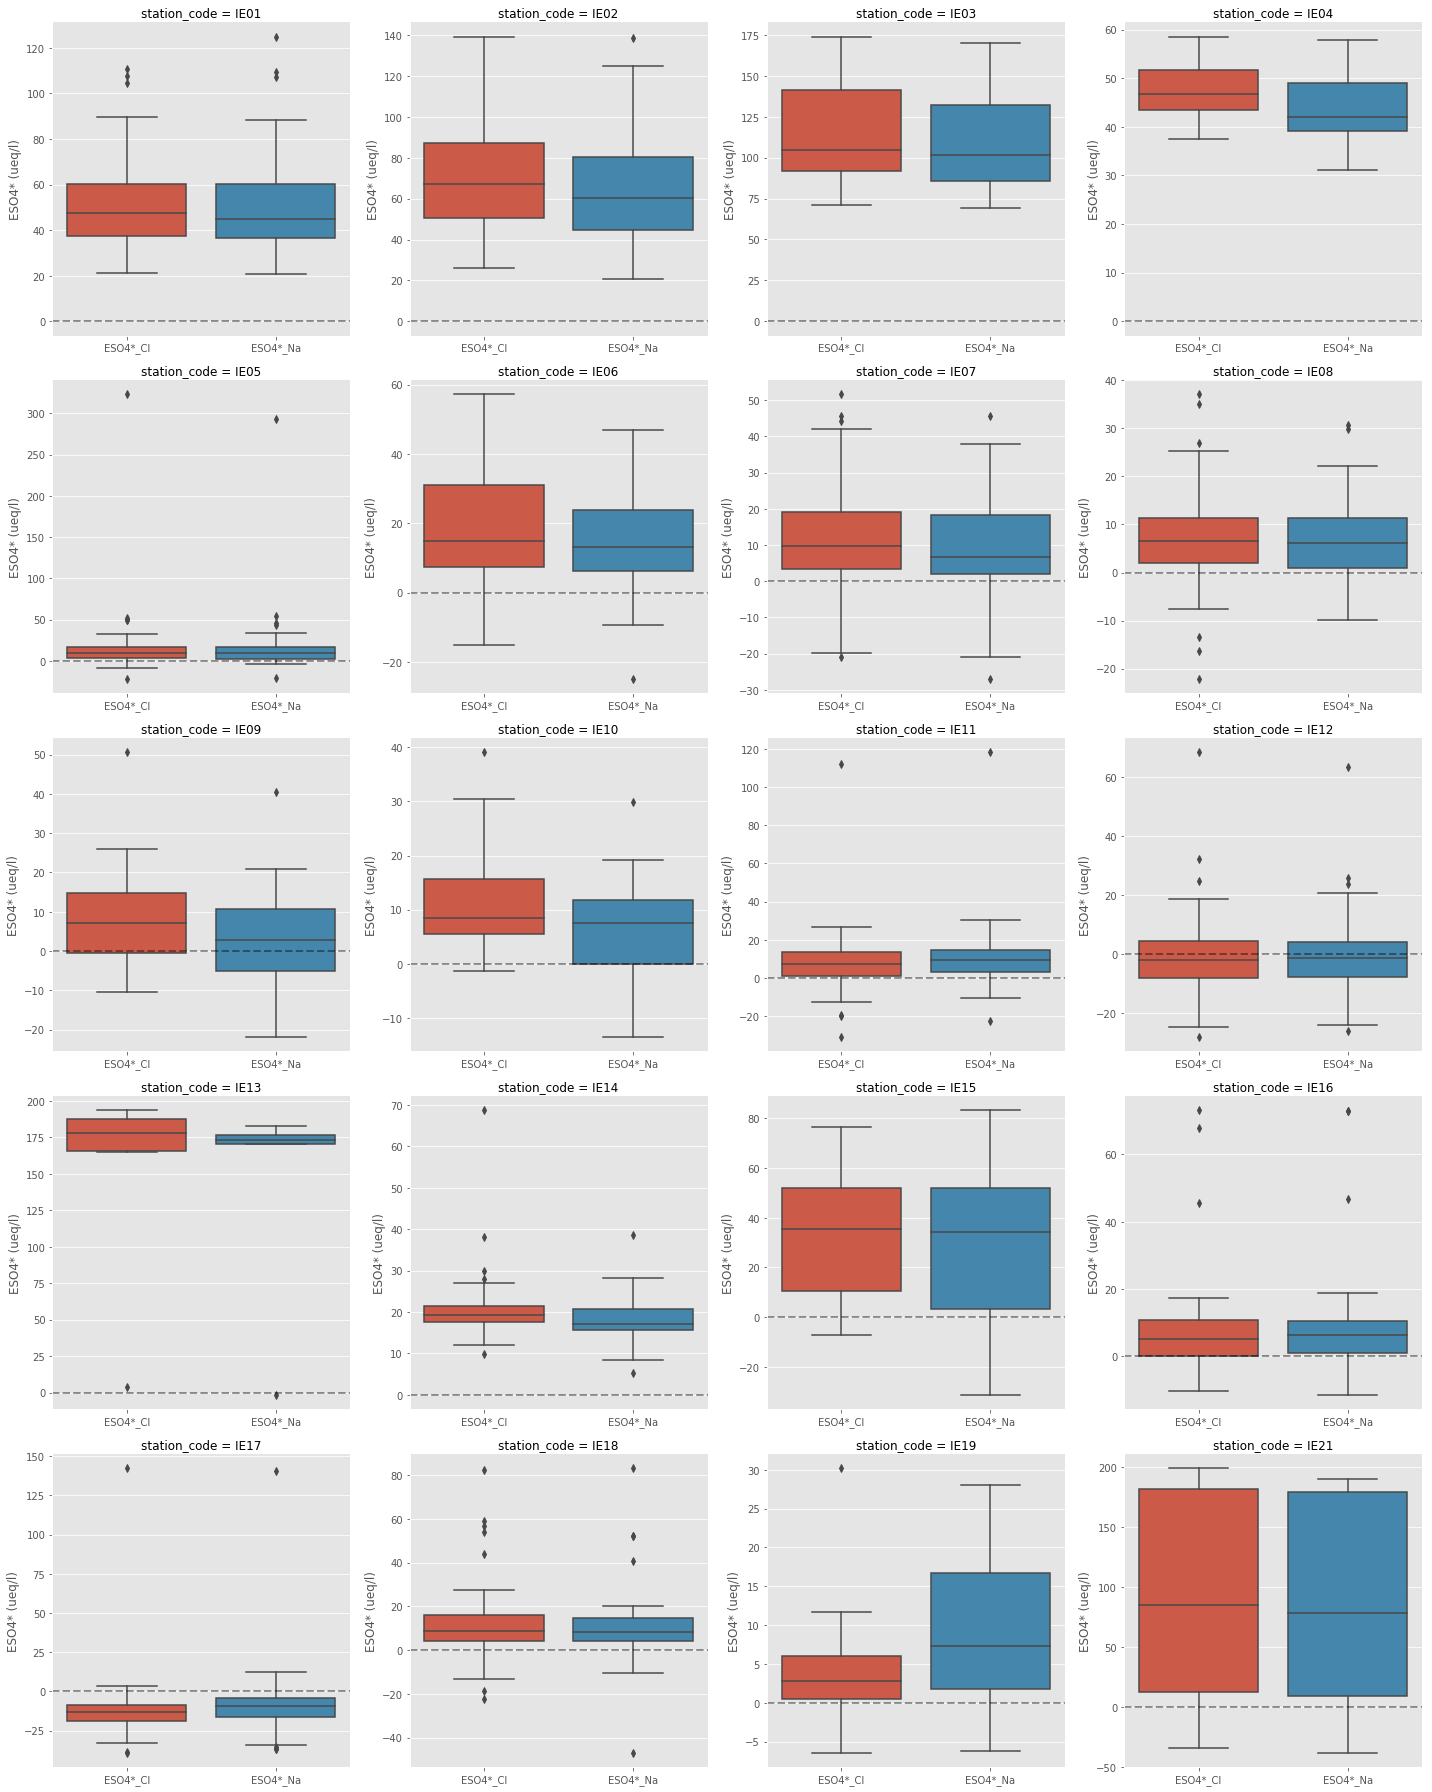

In [6]:
# Par of interest
par = 'ESO4'

df['%s*_Na' % par] = df[par] - (corr_facs['%s2na' % par[1:].lower()] * df['ENa'])
df['%s*_Cl' % par] = df[par] - (corr_facs['%s2cl' % par[1:].lower()] * df['ECl'])

df2 = df[['station_code', '%s*_Cl' % par, '%s*_Na' % par]]

df2 = df2.melt(id_vars=['station_code'], var_name='corr_method')
df2 = df2.dropna(how='any').reset_index(drop=True)

g = sn.catplot(x='corr_method',
               y='value',
               data=df2,
               col='station_code',
               col_wrap=4,
               kind='box',
               sharex=False,
               sharey=False,
              )

g.map(plt.axhline, y=0, lw=2, ls='--', c='k', alpha=0.4)
g.set(ylabel='%s* (ueq/l)' % par)
plt.tight_layout()

Overall, the results using Na are not much different from Cl: using Na marginally improves the situation at some locations, but actually makes it slightly worse at others. In general, it seems that Na and Cl are both high at these station, so either the labs have a tendency to overestimate both these parameters, or else the lakes really are just surprisingly "salty" compared to other parameters. 

Some of these results are quite extreme: at station IE12 (`Galway, Bofin, Mid Lake`), for example, more than half of ESO4* values are negative, while at IE17 (`Galway, Fadda, Mid Lake`) more than 75% of the "corrected" values are less than zero (regardless of whether Na or Cl is used as a tracer). I wonder if there's anything unusual about these two lakes in particular that could give a clue as to what's happening elsewhere?